# Patient-Level ICU Mortality Analysis

Analyze ICU mortality rate on patient level for both datasets.


In [9]:
# Setup
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Add project root to path
project_root = Path().resolve().parent.parent
sys.path.insert(0, str(project_root))

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11


In [10]:
# Import required modules
from src.data.ecg.ecg_loader import build_demo_index  # For WFDB .hea/.dat files
from src.data.ecg.ecg_dataset import extract_subject_id_from_path
from src.data.labeling import load_icustays
from typing import Set, Dict, List
import pandas as pd

# Define functions
def get_unique_patients_from_dataset(data_dir: Path) -> Set[int]:
    """Extract unique subject_ids from ECG files in a dataset directory.
    
    Works with both WFDB format (.hea/.dat) and preprocessed .npy files.
    """
    if not data_dir.exists():
        return set()
    
    print(f"  Scanning ECG files in: {data_dir}")
    
    # Try WFDB format first (original files), fall back to .npy if not found
    try:
        records = build_demo_index(data_dir=str(data_dir))
        print(f"  Found {len(records):,} ECG files (WFDB format)")
    except (FileNotFoundError, RuntimeError):
        # Fall back to .npy files if WFDB not found
        from src.data.ecg.ecg_loader import build_npy_index
        try:
            records = build_npy_index(data_dir=str(data_dir))
            print(f"  Found {len(records):,} ECG files (.npy format)")
        except (FileNotFoundError, RuntimeError):
            print(f"  Warning: No ECG files found in {data_dir}")
            return set()
    
    unique_patients = set()
    for record in records:
        base_path = record["base_path"]
        try:
            subject_id = extract_subject_id_from_path(base_path)
            unique_patients.add(subject_id)
        except Exception:
            continue
    
    print(f"  Extracted {len(unique_patients):,} unique patients")
    return unique_patients

def analyze_patient_mortality(
    dataset_name: str,
    data_dir: Path,
    icustays_df: pd.DataFrame,
    admissions_df: pd.DataFrame
) -> Dict:
    """Calculate ICU mortality rate on patient level and ECG level."""
    print(f"\n{'='*80}")
    print(f"Analyzing dataset: {dataset_name}")
    print(f"{'='*80}")
    
    unique_patients = get_unique_patients_from_dataset(data_dir)
    
    if len(unique_patients) == 0:
        print(f"  Warning: No patients found in dataset {dataset_name}")
        return None
    
    dataset_icustays = icustays_df[icustays_df['subject_id'].isin(unique_patients)].copy()
    dataset_icustays['intime'] = pd.to_datetime(dataset_icustays['intime'])
    dataset_icustays['outtime'] = pd.to_datetime(dataset_icustays['outtime'])
    
    print(f"  Found ICU stays for {len(dataset_icustays):,} patients")
    
    admissions_with_deathtime = admissions_df[['hadm_id', 'deathtime']].copy()
    admissions_with_deathtime['deathtime'] = pd.to_datetime(admissions_with_deathtime['deathtime'], errors='coerce')
    
    icustays_with_death = dataset_icustays.merge(
        admissions_with_deathtime,
        on='hadm_id',
        how='left'
    )
    
    icustays_with_death['died_in_icu'] = (
        icustays_with_death['deathtime'].notna() &
        (icustays_with_death['deathtime'] >= icustays_with_death['intime']) &
        (icustays_with_death['deathtime'] <= icustays_with_death['outtime'])
    )
    
    # Patient-level analysis
    patient_died_in_icu = icustays_with_death.groupby('subject_id')['died_in_icu'].any()
    
    died_patients = patient_died_in_icu.sum()
    alive_patients = len(patient_died_in_icu) - died_patients
    total_patients = len(patient_died_in_icu)
    mortality_rate = (died_patients / total_patients * 100) if total_patients > 0 else 0.0
    
    print(f"\n  Patient-Level Results for {dataset_name}:")
    print(f"    Total patients: {total_patients:,}")
    print(f"    Died: {died_patients:,} ({mortality_rate:.2f}%)")
    print(f"    Survived: {alive_patients:,} ({100 - mortality_rate:.2f}%)")
    
    # ECG-level analysis: Count ECGs from patients who died
    print(f"\n  ECG-Level Analysis:")
    print(f"    Counting ECGs from patients...")
    
    # Get all ECGs from dataset
    try:
        from src.data.ecg.ecg_loader import build_demo_index
        records = build_demo_index(data_dir=str(data_dir))
        print(f"    Found {len(records):,} ECG files")
    except (FileNotFoundError, RuntimeError):
        from src.data.ecg.ecg_loader import build_npy_index
        try:
            records = build_npy_index(data_dir=str(data_dir))
            print(f"    Found {len(records):,} ECG files (.npy format)")
        except (FileNotFoundError, RuntimeError):
            records = []
    
    # Create mapping: subject_id -> died (True/False)
    patient_died_map = patient_died_in_icu.to_dict()
    
    # Count ECGs from died vs survived patients
    ecgs_from_died = 0
    ecgs_from_survived = 0
    ecgs_unmatched = 0
    
    for record in records:
        base_path = record["base_path"]
        try:
            subject_id = extract_subject_id_from_path(base_path)
            if subject_id in patient_died_map:
                if patient_died_map[subject_id]:
                    ecgs_from_died += 1
                else:
                    ecgs_from_survived += 1
            else:
                ecgs_unmatched += 1
        except Exception:
            ecgs_unmatched += 1
    
    total_ecgs = ecgs_from_died + ecgs_from_survived
    ecg_mortality_rate = (ecgs_from_died / total_ecgs * 100) if total_ecgs > 0 else 0.0
    
    print(f"    Total ECGs: {total_ecgs:,}")
    print(f"    ECGs from died patients: {ecgs_from_died:,} ({ecg_mortality_rate:.2f}%)")
    print(f"    ECGs from survived patients: {ecgs_from_survived:,} ({100 - ecg_mortality_rate:.2f}%)")
    if ecgs_unmatched > 0:
        print(f"    ECGs unmatched: {ecgs_unmatched:,}")
    
    return {
        'dataset_name': dataset_name,
        'total_patients': total_patients,
        'died_patients': died_patients,
        'alive_patients': alive_patients,
        'mortality_rate': mortality_rate,
        'total_ecgs': total_ecgs,
        'ecgs_from_died': ecgs_from_died,
        'ecgs_from_survived': ecgs_from_survived,
        'ecg_mortality_rate': ecg_mortality_rate
    }


In [11]:
# Load data
# Use absolute paths relative to project root
icustays_path = project_root / "data/labeling/labels_csv/icustays.csv"
admissions_path = project_root / "data/labeling/labels_csv/admissions.csv"

print(f"Loading ICU stays from: {icustays_path}")
print(f"Loading admissions from: {admissions_path}")

if not icustays_path.exists():
    raise FileNotFoundError(f"ICU stays file not found: {icustays_path}")
if not admissions_path.exists():
    raise FileNotFoundError(f"Admissions file not found: {admissions_path}")

# Reload the module to ensure we have the latest version
import importlib
from src.data.labeling import icu_los_labels
importlib.reload(icu_los_labels)
from src.data.labeling.icu_los_labels import load_icustays

icustays_df = load_icustays(str(icustays_path))
admissions_df = pd.read_csv(str(admissions_path))

print(f"Loaded {len(icustays_df):,} ICU stays")
print(f"Loaded {len(admissions_df):,} admissions")

# Verify hadm_id is present
if 'hadm_id' not in icustays_df.columns:
    print("WARNING: hadm_id column not found in icustays_df. Mortality analysis may fail.")
    print(f"Available columns: {list(icustays_df.columns)}")
else:
    print(f"✓ hadm_id column found in icustays_df")


Loading ICU stays from: /pfs/data6/home/ka/ka_aifb/ka_zx9981/workspace/ma-thesis/MA-thesis-1/data/labeling/labels_csv/icustays.csv
Loading admissions from: /pfs/data6/home/ka/ka_aifb/ka_zx9981/workspace/ma-thesis/MA-thesis-1/data/labeling/labels_csv/admissions.csv
Loaded 94,458 ICU stays
Loaded 546,028 admissions
✓ hadm_id column found in icustays_df


In [12]:
# Analyze both datasets
# Using original WFDB files (.hea/.dat) from 'original' subdirectories
# Use absolute paths relative to project root
datasets = {
    'all_icu_ecgs': {
        'name': 'All ICU ECGs',
        'data_dir': project_root / 'data/all_icu_ecgs/original'
    },
    'icu_24h': {
        'name': 'ICU 24h',
        'data_dir': project_root / 'data/icu_ecgs_24h/original'
    }
}

results = []
for dataset_key, dataset_info in datasets.items():
    if dataset_info['data_dir'].exists():
        result = analyze_patient_mortality(
            dataset_name=dataset_info['name'],
            data_dir=dataset_info['data_dir'],
            icustays_df=icustays_df,
            admissions_df=admissions_df
        )
        if result:
            results.append(result)
    else:
        print(f"Dataset {dataset_info['name']} not found at {dataset_info['data_dir']}")



Analyzing dataset: All ICU ECGs
  Scanning ECG files in: /pfs/data6/home/ka/ka_aifb/ka_zx9981/workspace/ma-thesis/MA-thesis-1/data/all_icu_ecgs/original
  Found 61,663 ECG files (WFDB format)
  Extracted 24,394 unique patients
  Found ICU stays for 41,939 patients

  Patient-Level Results for All ICU ECGs:
    Total patients: 24,394
    Died: 3,105 (12.73%)
    Survived: 21,289 (87.27%)

  ECG-Level Analysis:
    Counting ECGs from patients...
    Found 61,663 ECG files
    Total ECGs: 61,663
    ECGs from died patients: 11,244 (18.23%)
    ECGs from survived patients: 50,419 (81.77%)

Analyzing dataset: ICU 24h
  Scanning ECG files in: /pfs/data6/home/ka/ka_aifb/ka_zx9981/workspace/ma-thesis/MA-thesis-1/data/icu_ecgs_24h/original
  Found 34,838 ECG files (WFDB format)
  Extracted 21,408 unique patients
  Found ICU stays for 37,461 patients

  Patient-Level Results for ICU 24h:
    Total patients: 21,408
    Died: 2,608 (12.18%)
    Survived: 18,800 (87.82%)

  ECG-Level Analysis:
   

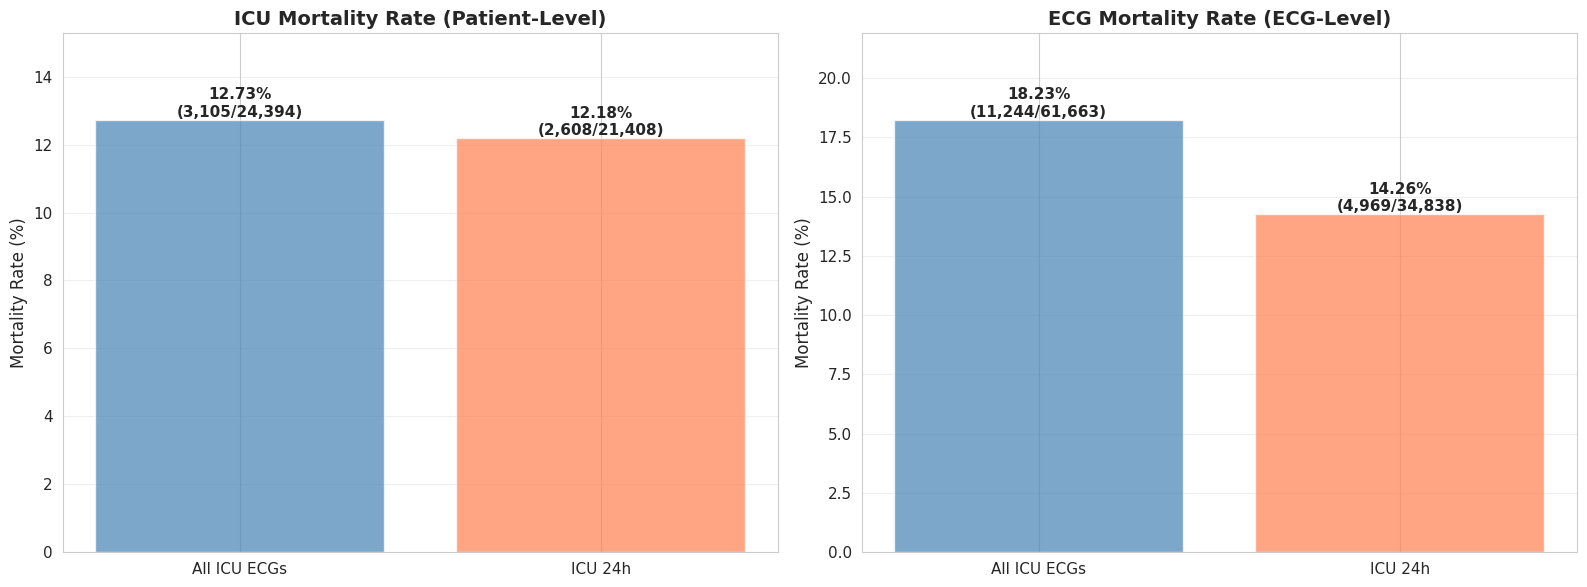


SUMMARY TABLE - Patient-Level
dataset_name  total_patients  died_patients  alive_patients  mortality_rate
All ICU ECGs           24394           3105           21289       12.728540
     ICU 24h           21408           2608           18800       12.182362

SUMMARY TABLE - ECG-Level
dataset_name  total_ecgs  ecgs_from_died  ecgs_from_survived  ecg_mortality_rate
All ICU ECGs       61663           11244               50419           18.234598
     ICU 24h       34838            4969               29869           14.263161


In [13]:
# Visualize results
if results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    datasets_names = [r['dataset_name'] for r in results]
    
    # Patient-level chart
    patient_mortality_rates = [r['mortality_rate'] for r in results]
    bars1 = ax1.bar(datasets_names, patient_mortality_rates, color=['steelblue', 'coral'], alpha=0.7)
    
    ax1.set_ylabel('Mortality Rate (%)', fontsize=12)
    ax1.set_title('ICU Mortality Rate (Patient-Level)', fontsize=14, fontweight='bold')
    ax1.set_ylim(0, max(patient_mortality_rates) * 1.2)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, rate, result in zip(bars1, patient_mortality_rates, results):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{rate:.2f}%\n({result["died_patients"]:,}/{result["total_patients"]:,})',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # ECG-level chart
    ecg_mortality_rates = [r['ecg_mortality_rate'] for r in results]
    bars2 = ax2.bar(datasets_names, ecg_mortality_rates, color=['steelblue', 'coral'], alpha=0.7)
    
    ax2.set_ylabel('Mortality Rate (%)', fontsize=12)
    ax2.set_title('ECG Mortality Rate (ECG-Level)', fontsize=14, fontweight='bold')
    ax2.set_ylim(0, max(ecg_mortality_rates) * 1.2)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, rate, result in zip(bars2, ecg_mortality_rates, results):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{rate:.2f}%\n({result["ecgs_from_died"]:,}/{result["total_ecgs"]:,})',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n" + "="*80)
    print("SUMMARY TABLE - Patient-Level")
    print("="*80)
    patient_df = pd.DataFrame([{
        'dataset_name': r['dataset_name'],
        'total_patients': r['total_patients'],
        'died_patients': r['died_patients'],
        'alive_patients': r['alive_patients'],
        'mortality_rate': r['mortality_rate']
    } for r in results])
    print(patient_df.to_string(index=False))
    
    print("\n" + "="*80)
    print("SUMMARY TABLE - ECG-Level")
    print("="*80)
    ecg_df = pd.DataFrame([{
        'dataset_name': r['dataset_name'],
        'total_ecgs': r['total_ecgs'],
        'ecgs_from_died': r['ecgs_from_died'],
        'ecgs_from_survived': r['ecgs_from_survived'],
        'ecg_mortality_rate': r['ecg_mortality_rate']
    } for r in results])
    print(ecg_df.to_string(index=False))
